In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

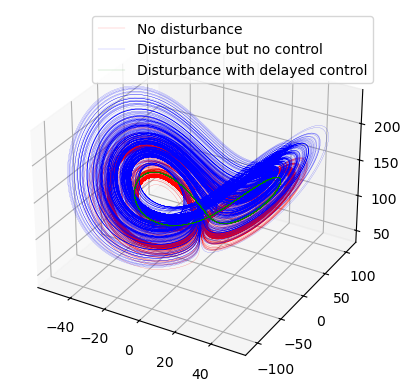

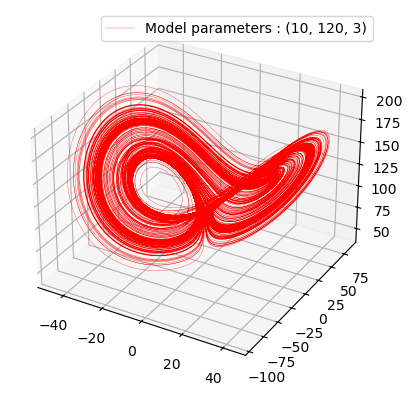

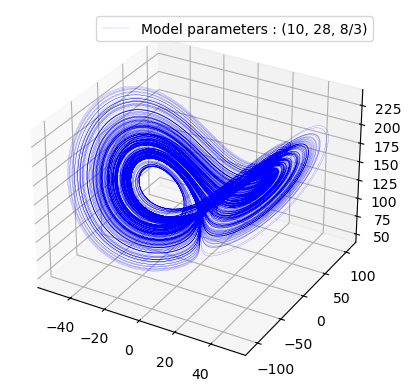

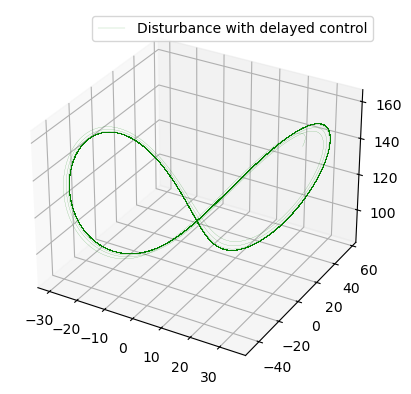

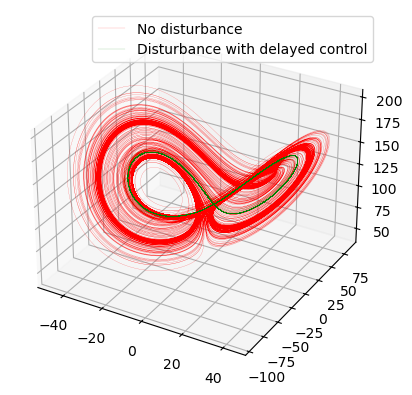

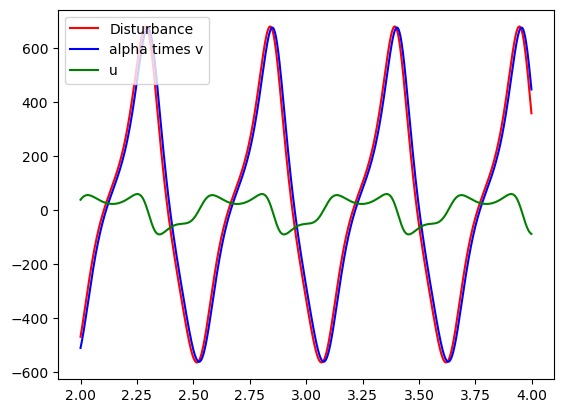

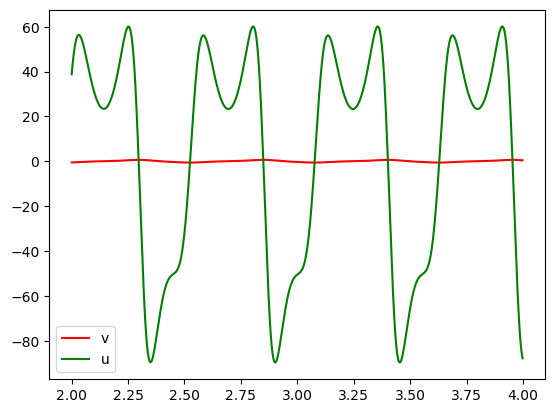

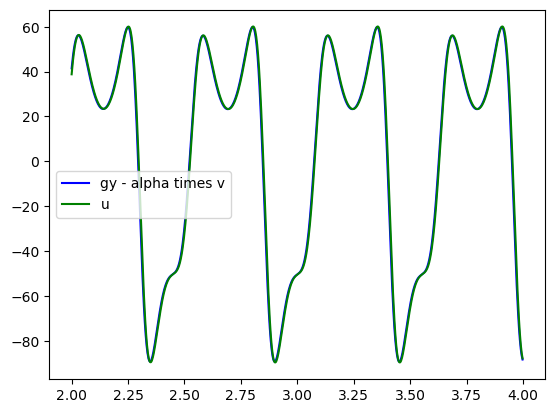

In [10]:
## Lorenz system parameters 
sigma = 10
rho = 120
beta = 3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                    # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Control parameters
alpha = 1000
tau = 10

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Inital state of Lorenz system, reservoir states and forcing function
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))


### Training using the pre-defined forcing functions ###

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r

    fx = 10 * np.cos(0.05 * dt * t)
    fy = 10 * np.sin(0.05 * dt * t)
    
    f[0, t] = fx
    f[1, t] = fy

    xp = sigma * (y - x) + fx
    yp = x * (rho - z) - y + fy
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    r = np.tanh(A.dot(r) + Win.dot(u) + 1)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))




### Testing delayed control with altered rho ###

Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

gxnocontrol = np.zeros(ntest)
gxcontrol = np.zeros(ntest)
ux = np.zeros(ntest + 1)
vx = np.zeros(ntest + 1)

gynocontrol = np.zeros(ntest)
gycontrol = np.zeros(ntest)
uy = np.zeros(ntest + 1)
vy = np.zeros(ntest + 1)

gznocontrol = np.zeros(ntest)
gzcontrol = np.zeros(ntest)
uz = np.zeros(ntest + 1)
vz = np.zeros(ntest + 1)

## Storing x, y, z time series data when there is disturbance and control is applied
xcontrol = np.zeros(ntest)             
ycontrol = np.zeros(ntest)
zcontrol = np.zeros(ntest)

## Storing x, y, z time series data when there is disturbance and control is not applied
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## Storing x, y, z time series data if there was no disturbance
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)


xxcontrol, yycontrol, zzcontrol = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpure, yypure, zzpure = x, y, z



for t in range(ntest):

    ## No disturbance and system is evolving with old parameters

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure    
    
    

    ## Disturbance but no control
    
    gynocontrol[t] = 20 * xxnocontrol


    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + gynocontrol[t]
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol



    ## Disturbance with delayed control

    gycontrol[t] = 20 * xxcontrol
    

    ux[t], uy[t], uz[t] = Wout.dot(r)

    vx[t + 1] = vx[t] + (dt / tau) * (ux[t] - vx[t])
    vy[t + 1] = vy[t] + (dt / tau) * (uy[t] - vy[t])
    vz[t + 1] = vz[t] + (dt / tau) * (uz[t] - vz[t])

    xxcontrolp = sigma * (yycontrol - xxcontrol) + gxcontrol[t] - alpha * vx[t]
    yycontrolp = xxcontrol * (rho - zzcontrol) - yycontrol + gycontrol[t] - alpha * vy[t]
    zzcontrolp = xxcontrol * yycontrol - beta * zzcontrol + gzcontrol[t] - alpha * vz[t]

    xxcontrol += dt * xxcontrolp
    yycontrol += dt * yycontrolp
    zzcontrol += dt * zzcontrolp

    xcontrol[t] = xxcontrol
    ycontrol[t] = yycontrol
    zcontrol[t] = zzcontrol

    r = np.tanh(A.dot(r) + Win.dot(np.array([xxcontrol, yycontrol, zzcontrol])) + 1)
    




plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.2, label = 'Model parameters : (10, 120, 3)')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Model parameters : (10, 28, 8/3)')
plt.legend()
plt.show()

plt.figure()

ax = plt.axes(projection = '3d')
ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xcontrol, ycontrol, zcontrol, 'g', linewidth = 0.1, label = 'Disturbance with delayed control')
plt.legend()
plt.show()

timerange = range(1000, 2000)
plt.figure()
ax = plt.axes()
ax.plot(testingtimes[timerange], gycontrol[timerange],'r', label = 'Disturbance')
ax.plot(testingtimes[timerange], alpha * vy[timerange], 'b', label = 'alpha times v')
ax.plot(testingtimes[timerange], uy[timerange], 'g', label = 'u')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes()
ax.plot(testingtimes[timerange], vy[timerange], 'r', label = 'v')
ax.plot(testingtimes[timerange], uy[timerange], 'g', label = 'u')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes()
ax.plot(testingtimes[timerange], gycontrol[timerange] - alpha * vy[timerange], 'b', 
        label = 'gy - alpha times v')
ax.plot(testingtimes[timerange], uy[timerange], 'g', label = 'u')
plt.legend()
plt.show()

